In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats

# increase columns and rows for display to have a better view of the dataframe
pd.set_option("display.max_columns", 100)
pd.set_option("display.min_rows", 100)

%matplotlib inline

In [62]:
df = pd.read_csv('constr_price_cost_monthly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17905 entries, 0 to 17904
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     17905 non-null  object 
 1   LAST UPDATE  17905 non-null  object 
 2   freq         17905 non-null  object 
 3   indic_bt     17905 non-null  object 
 4   cpa2_1       17905 non-null  object 
 5   s_adj        17905 non-null  object 
 6   unit         17905 non-null  object 
 7   geo          17905 non-null  object 
 8   TIME_PERIOD  17905 non-null  object 
 9   OBS_VALUE    17905 non-null  float64
 10  OBS_FLAG     9341 non-null   object 
dtypes: float64(1), object(10)
memory usage: 1.5+ MB


indic_bt:
- CSTO : Output price index in construction

cpa2_1:
- CPA_F41001_X_410014 : Residential buildings, except residences for communities

unit:
- I15 : Index, 2015=100       

In [63]:
df = df[(df['unit']=='I15')&(df['geo']=='IE')]
df = df[['TIME_PERIOD','indic_bt','OBS_VALUE']]
df = df.pivot_table('OBS_VALUE',['TIME_PERIOD'],'indic_bt')
df.reset_index(drop=False, inplace=True)

df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')
df.set_index('TIME_PERIOD', inplace=True)
df.head()

indic_bt,CSTO
TIME_PERIOD,
2000-01-01,59.8
2000-02-01,59.8
2000-03-01,61.2
2000-04-01,62.6
2000-05-01,64.1


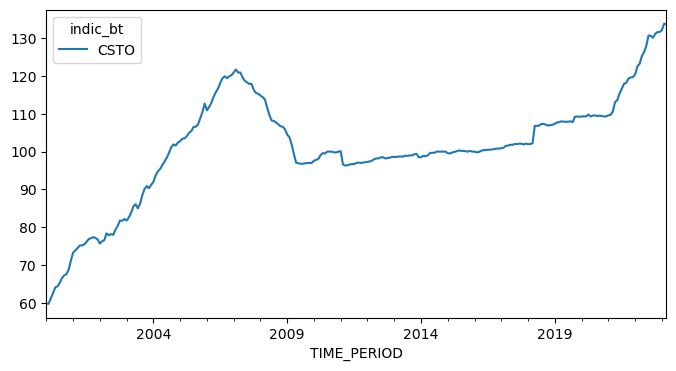

In [65]:
df.plot(figsize=(8,4),legend=True);

In [66]:
from pmdarima import auto_arima
import warnings

warnings.filterwarnings('ignore')

stepwise_fit = auto_arima(df['CSTO'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=618.077, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=722.239, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=677.855, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=619.678, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=618.115, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=618.066, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=616.164, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=616.244, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=661.664, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=618.156, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.960 seconds


In [67]:
print(df.shape)

(279, 1)


In [68]:
train=df.iloc[:-20]
test=df.iloc[-20:]
print(train.shape,test.shape)

(259, 1) (20, 1)


In [69]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train['CSTO'],order=(1,2,1))
model=model.fit()
#model.summary()

In [70]:
# Prediction start and end index
start=len(train) #star to make prediction from the end of training set
end=len(train)+len(test)-1

# Make prediction
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
print(pred)

2021-08-01    117.461626
2021-09-01    118.239089
2021-10-01    119.000395
2021-11-01    119.758599
2021-12-01    120.516208
2022-01-01    121.273701
2022-02-01    122.031173
2022-03-01    122.788641
2022-04-01    123.546108
2022-05-01    124.303575
2022-06-01    125.061042
2022-07-01    125.818509
2022-08-01    126.575975
2022-09-01    127.333442
2022-10-01    128.090909
2022-11-01    128.848376
2022-12-01    129.605842
2023-01-01    130.363309
2023-02-01    131.120776
2023-03-01    131.878243
Freq: MS, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:xlabel='TIME_PERIOD'>

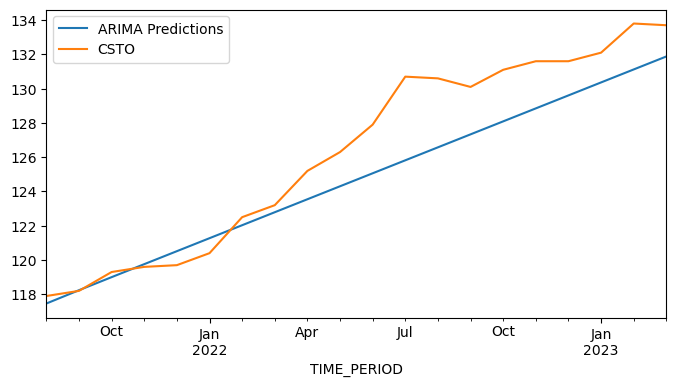

In [75]:
pred.plot(figsize=(8,4),legend=True)
test['CSTO'].plot(legend=True)

In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mean = test['CSTO'].mean()
rmse = sqrt(mean_squared_error(pred,test['CSTO']))

print('mean = ', mean)
print('mean sqr err = ', rmse)

mean =  126.27499999999998
mean sqr err =  2.2214790255893577


model is good, apply to entire dataset to make predictions into the future

In [83]:
model2 = ARIMA(df['CSTO'],order=(1,2,1))
model2 = model2.fit()

df.tail()

indic_bt,CSTO
TIME_PERIOD,
2022-11-01,131.6
2022-12-01,131.6
2023-01-01,132.1
2023-02-01,133.8
2023-03-01,133.7


In [84]:
# index_future_dates = pd.date_range(start='2023-03-01', end='2024-03-01', freq='MS') # MS first day of month
# print(index_future_dates)

In [85]:
pred = model2.predict(start=len(df), end=len(df)+24, typ='levels').rename('ARIMA Predictions')
print(pred)

2023-04-01    134.255346
2023-05-01    134.926263
2023-06-01    135.617560
2023-07-01    136.312451
2023-08-01    137.007977
2023-09-01    137.703613
2023-10-01    138.399270
2023-11-01    139.094930
2023-12-01    139.790591
2024-01-01    140.486252
2024-02-01    141.181913
2024-03-01    141.877574
2024-04-01    142.573234
2024-05-01    143.268895
2024-06-01    143.964556
2024-07-01    144.660217
2024-08-01    145.355878
2024-09-01    146.051539
2024-10-01    146.747200
2024-11-01    147.442860
2024-12-01    148.138521
2025-01-01    148.834182
2025-02-01    149.529843
2025-03-01    150.225504
2025-04-01    150.921165
Freq: MS, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

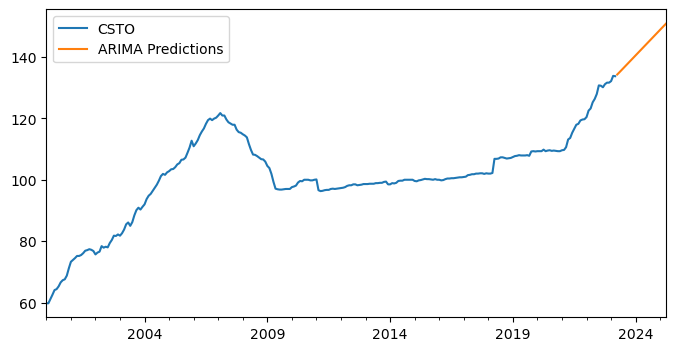

In [86]:
df2['CSTO'].plot(figsize=(8,4),legend=True)
pred.plot(legend=True)